In [276]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# set paths/create objects

cp1 = day-0

cp2 = day-n

In [277]:
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171121_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171214_No Obstacles_s.mat'


cp1 = CortProcessor(cp1_path)
cp2 = CortProcessor(cp2_path)

cca_object = CCAProcessor(cp1, cp2)

this is filipe data i belive
this is filipe data i belive
should be good to align
(7305, 25)
(7305, 5)
(7305, 23)
(7305, 5)


# Getting PCA dimensions

In [278]:
#dimensions is lower of PCA95%
temp, nada, nada = cca_object.apply_PCA()
lowest_num_dimensions = 8
print(lowest_num_dimensions)

8


# storing day-n raw (unaligned, unprocessed) data as test sets

In [279]:
#get unprocessed day2 neural data as test set
test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions)))
test_y = np.squeeze(np.array(cp2.data['angles']))

test_x_format, test_y_format = format_data(test_x, test_y)

#scaled version
scaler = StandardScaler()
test_x_scale = scaler.fit_transform(test_x)

test_x_format_scale, nada = format_data(test_x_scale, test_y)

# choosing subsampling list

In [280]:
#percent of total data
subsample_list = [.05, .1, .2, .5, 1.0]

# getting day0 decoder
apply PCA, and then train wiener filter.
also get a day0-scaled-weights-decoder

In [281]:
#get day0 decoder weights, scaled + unscaled versions

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(lowest_num_dimensions))
print(np.average(nada, 1)[1])

X_tempy =cp1.apply_PCA(lowest_num_dimensions)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=[X_scale])

print(np.average(nada, 1)[1])

0.43200000000000005
0.43200000000000005


# getting JUST-PCA decoder
we subsample day-n data, apply PCA, and then train a wiener filter on it to spit out a decoder. Then we try decoder on the day2-test set

In [282]:
pca_decoder = []

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)
    
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    pca_decoder.append(temp_h)

# getting CCA scores

In [283]:
cca_decoder_scores = []
cca_transformers=[]
love_y1=[]
love_y2=[]
for i in range(len(subsample_list)):
    sub_x1, sub_y1, sub_x2, sub_y2 = cca_object.subsample(percent = subsample_list[i])
    love_y1.append(sub_y1)
    love_y2.append(sub_y2)
    nada, pca_sub_x1, pca_sub_x2 = cca_object.apply_PCA(cp1_x = sub_x1, cp2_x = sub_x2, preset_num_components=lowest_num_dimensions)
    temp_cca_transformer, sanity_x = cca_object.apply_CCA(cp1_x = pca_sub_x1, cp2_x = pca_sub_x2, preset_num_components = lowest_num_dimensions)
    nada, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
    temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
    
    cca_transformers.append(temp_cca_transformer)
    
    temp_x_format, nada = format_data(temp_x, test_y)
    
    predic = test_wiener_filter(temp_x_format, day0_decoder)
    
    #sanity checks
    sanity_x_format, sanity_y_format = format_data(sanity_x, cca_object.data['cp2']['proc_y'])
    predic_sanity = test_wiener_filter(sanity_x_format, day0_decoder)
    print(vaf(sanity_y_format[:,1], predic_sanity[:,1]))
    

    cca_decoder_scores.append(vaf(test_y_format[:,1], predic[:,1]))
    


0.13
-0.2
0.14
0.29
0.28


# getting regression decoder

In [284]:
r_decoder = []

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = np.squeeze(cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x))
    
    nada, sub_x_cca_space = cca_transformers[i].transform(sub_x_pca, sub_x_pca)
    temp_x = cca_transformers[i].inverse_transform(sub_x_cca_space)
    
    scaler = StandardScaler()
    sub_x_pca_scale = scaler.fit_transform(temp_x)

    wpost = regression_fit(b0=day0_decoder_scale, x=sub_x_pca_scale, y=np.squeeze(sub_y), my_alpha=1.0)
    r_decoder.append(wpost)

# getting VAF scores for each decoder

In [285]:
fixed_decoder_scores=[]
pca_decoder_scores=[]
r_decoder_scores=[]

for i in range(len(subsample_list)):
    temp_y = test_wiener_filter(test_x_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, pca_decoder[i])
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format_scale, r_decoder[i])
    r_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

In [286]:
print(fixed_decoder_scores)
print(pca_decoder_scores)
print(cca_decoder_scores)
print(r_decoder_scores)

[0.0, 0.0, 0.0, 0.0, 0.0]
[0.02, 0.15, 0.17, 0.26, 0.28]
[0.01, -0.13, 0.08, 0.12, 0.12]
[-0.22, -0.28, -0.13, -0.01, -0.19]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
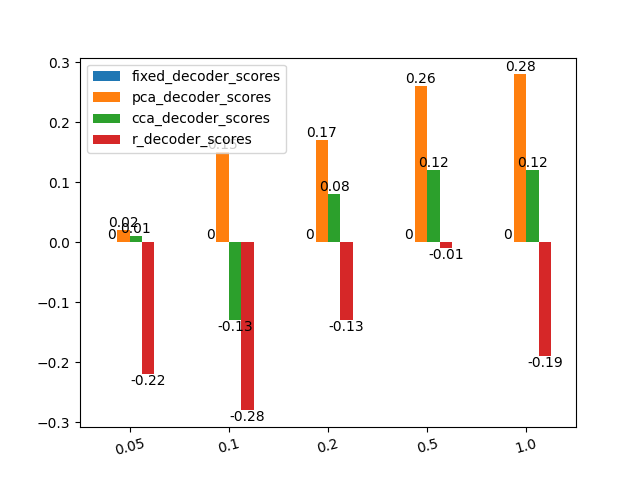

In [287]:
%matplotlib widget
%matplotlib widget

plot_dict = {}
plot_dict['fixed_decoder_scores'] = fixed_decoder_scores
plot_dict['pca_decoder_scores'] = pca_decoder_scores
plot_dict['cca_decoder_scores'] = cca_decoder_scores
plot_dict['r_decoder_scores'] = r_decoder_scores

index = subsample_list

df = pd.DataFrame(data=plot_dict, index=index)

  
# plot grouped bar chart
ax = df.plot.bar(rot=15)
for container in ax.containers:
    ax.bar_label(container)